In [41]:
import skimage.transform as tr
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model

In [43]:
class ModelClassifier:

    def CreateModel(size, channelNumber, numberOfClasses):
        if K.image_data_format() == "channels_first":
            shape = (channelNumber, size, size)
        else:
            shape = (size, size, channelNumber)
        model = keras.Sequential([
            keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
            keras.layers.MaxPooling2D(2,2),
            keras.layers.Conv2D(64, (3,3), activation='relu'),
            keras.layers.MaxPooling2D(2,2),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(1024, activation='relu'),
            
            keras.layers.Dense(numberOfClasses, activation="softmax")
        ])
        model.summary()

        model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
        return model

    def DataPreparation(image, labelsSides, labelsCorner, tileSize):
        [labelsSides,sidesCategories] = preprocess_labels(labelsSides)
        [labelsCorner,sornerCategories] = preprocess_labels(labelsCorner)


        image = ImagesRotation(image,tileSize)

        np.savez_compressed("SidesCategories.npz", sidesCategories)
        np.savez_compressed("CornerCategories.npz", sornerCategories)

        return [image,labelsSides,labelsCorner]

    def ImagesRotation(image,tileSize):
        tiles = [image[x:x+tileSize, y:y+tileSize] for x in range(0, image.shape[0], tileSize) for y in range(0, image.shape[1], tileSize)]
        new_images = np.zeros((len(tiles)*4, tileSize, tileSize, image.shape[2]), dtype=image.dtype)
        for i, tile in enumerate(tiles):
            for j in range(4):
                new_images[i*4+j] = np.rot90(tile, j)
        return new_images

    def TrainModels(data):
        train_images, test_images, train_labelsSides, test_labelsSides, train_labelsCorner, test_labelsCorner = train_test_split(data[0], data[1], data[2], test_size=0.2)
        SidesModel = CreateModel(data[0].shape[1],data[0].shape[-1],data[1].shape[1])
        CornersModel = CreateModel(data[0].shape[1],data[0].shape[-1],data[2].shape[1])
        if K.image_data_format() == "channels_first":
            train_images = train_images.reshape(train_images.shape[0], data[0].shape[-1],data[0].shape[1],data[0].shape[1])
            test_images = test_images.reshape(test_images.shape[0], data[0].shape[-1],data[0].shape[1],data[0].shape[1])
        else:
            train_images = train_images.reshape(train_images.shape[0], data[0].shape[1],data[0].shape[1],data[0].shape[-1])
            test_images = test_images.reshape(test_images.shape[0], data[0].shape[1],data[0].shape[1],data[0].shape[-1])
        
        trained_Sides = SidesModel.fit(train_images, train_labelsSides, epochs=12, validation_data=(test_images,test_labelsSides))  
        trained_Corners = CornersModel.fit(train_images, train_labelsCorner, epochs=12, validation_data=(test_images,test_labelsCorner)) 

        SidesModel.save("Sides.h5")
        CornersModel.save("Corners.h5")

    def onehot_to_categories(onehot_labels, category_names):
        categories = [category_names[np.argmax(label)] for label in onehot_labels]
        return categories

    def LoadModelAndPeridct(images, tileSize):
        sidesCategories = np.load("SidesCategories.npz")['arr_0']
        cornerCategories = np.load("SidesCategories.npz")['arr_0']

        sidesModel = load_model('Sides.h5')
        cornersModel = load_model('Corners.h5')

        image = ImagesRotation(image,tileSize)

        if K.image_data_format() == "channels_first":
            images = images.reshape(images.shape[0], data[0].shape[-1],data[0].shape[1],data[0].shape[1])
        else:
            images = images.reshape(images.shape[0], data[0].shape[1],data[0].shape[1],data[0].shape[-1])

        sidesPredicted = sidesModel.predict(images)
        cornersPredicted = cornersModel.predict(images)

        sidesDeencoded = np.zeros(sidesPredicted.shape[0])
        cornersDeencoded = np.zeros(sidesPredicted.shape[0])
        for i in sidesPredicted.shape[0]:
            sidesDeencoded[i] = onehot_to_categories(sidesPredicted[i],sidesCategories)
            cornersDeencoded[i] = onehot_to_categories(cornersPredicted[i],cornerCategories)
        return [sidesDeencoded,cornersDeencoded]


    def preprocess_labels(labels):
        labels_flat = labels.flatten().reshape(-1, 1)
        encoder = OneHotEncoder(sparse=False)
        labels_onehot = encoder.fit_transform(labels_flat)
        return [labels_onehot, encoder.categories_[0]]

32


C:\Users\Pc\AppData\Local\Temp\ipykernel_21208\3424592570.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


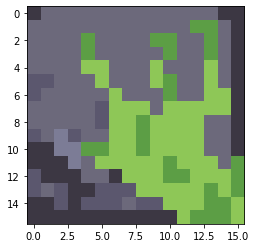

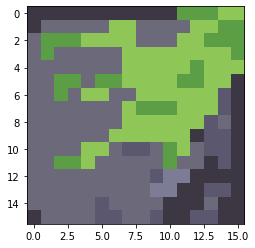

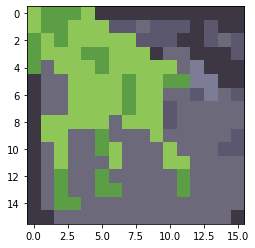

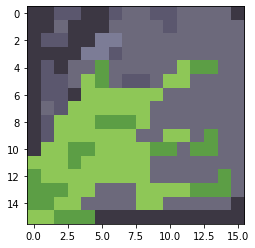

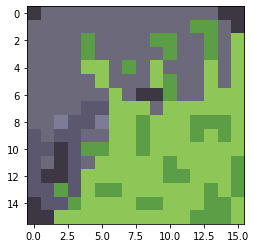

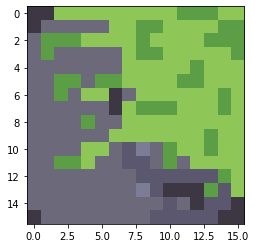

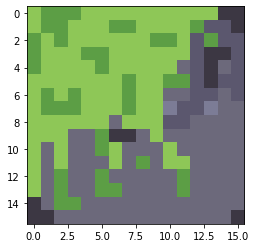

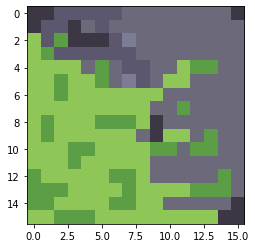

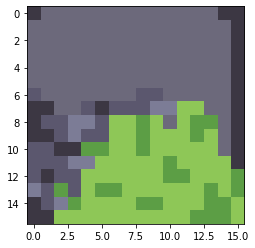

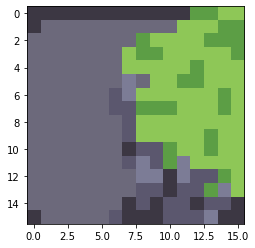

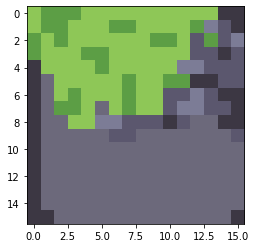

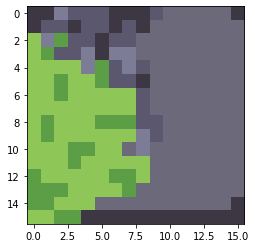

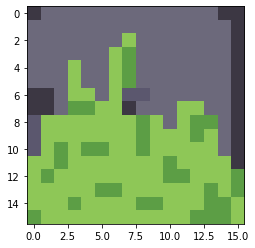

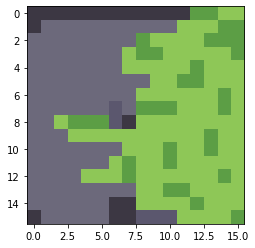

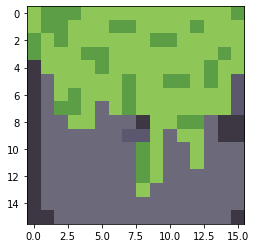

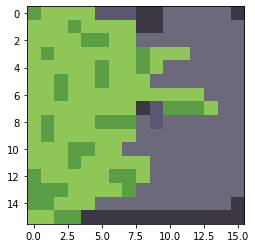

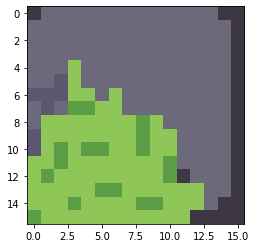

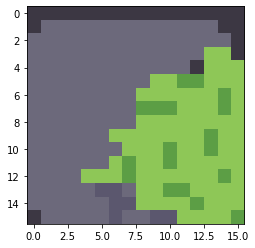

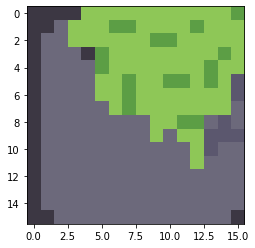

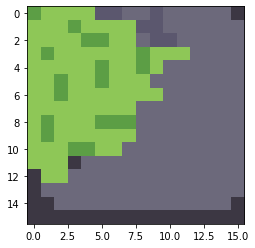

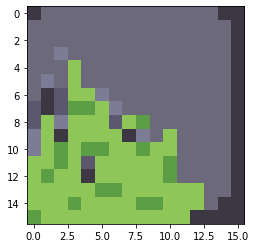

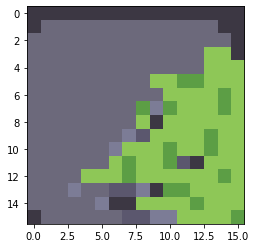

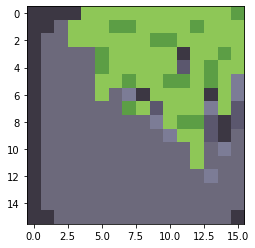

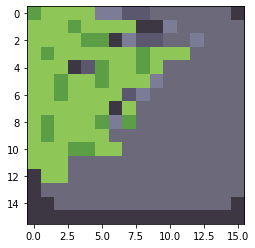

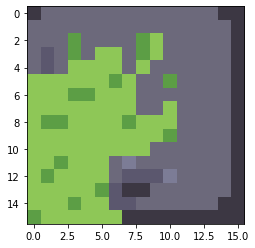

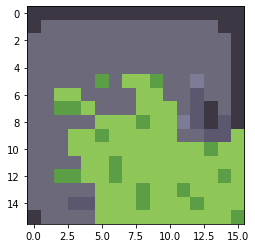

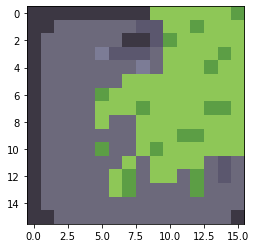

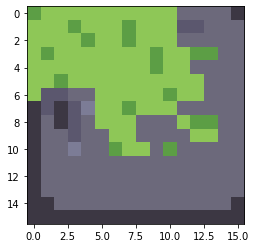

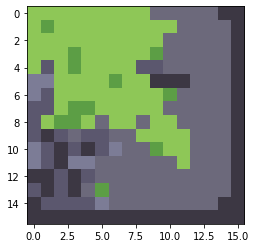

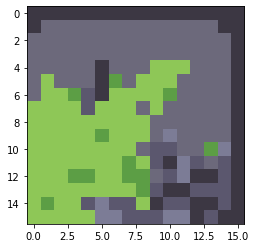

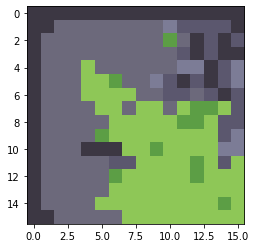

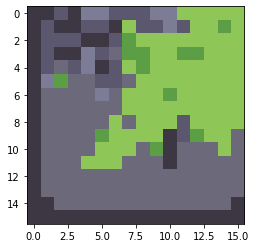

In [40]:

img = np.asarray(Image.open('D:/WFC-Layered-Model-Godot/Godot/Demo/Sprites/TileTests2.png'))
myClass = ModelClassifier()
images = ModelClassifier.DataPreparation(img,np.asanyarray([[1,2,3],[1,2,3]]), np.asanyarray([[1,2,3],[1,2,3]]), 16)
print(images[0].shape[0])
for i in range(images[0].shape[0]):
    plt.figure()
    plt.imshow(images[0][i])